In [ ]:
%pip install kagglehub

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("blanderbuss/parking-lot-dataset")

print("Path to dataset files:", path)

In [ ]:
import os
import shutil

source_dirs = [
    "PKLot/PKLot/PKLot/PUCPR/Cloudy",
    "PKLot/PKLot/PKLot/PUCPR/Sunny",
    "PKLot/PKLot/PKLot/PUCPR/Rainy",
    "PKLot/PKLot/PKLot/UFPR04/Cloudy",
    "PKLot/PKLot/PKLot/UFPR04/Sunny",
    "PKLot/PKLot/PKLot/UFPR04/Rainy",
    "PKLot/PKLot/PKLot/UFPR05/Cloudy",
    "PKLot/PKLot/PKLot/UFPR05/Sunny",
    "PKLot/PKLot/PKLot/UFPR05/Rainy"
]

output_dir = "dataset"
os.makedirs(output_dir, exist_ok=True) 

# Iterate over source directories and copy files
file_count = 0

for src_dir in source_dirs:
    for dirpath, _, files in os.walk(src_dir):
        for file in files:
            src_path = os.path.join(dirpath, file)
            dest_path = os.path.join(output_dir, file)

            shutil.copy(src_path, dest_path)
            file_count += 1

print(f"Successfully copied {file_count} files to {output_dir}.")

In [ ]:
# Remove the image that has no corresponding txt file
file_path = "dataset/2012-11-06_18_48_46.jpg"
try:
    os.remove(file_path)
    print(f"File '{file_path}' has been removed successfully.")
except OSError as e:
    print(f"Error removing the file '{file_path}': {e}")

In [ ]:
import xml.etree.ElementTree as ET
source_folder = "dataset"

# This is the size of photos in the dataset, thankfully the size is the same for every image
img_width, img_height = 1280, 720

# Process all XML files
for filename in os.listdir(source_folder):
    if filename.endswith(".xml"):
        xml_filepath = os.path.join(source_folder, filename)
        
        # Parse the XML file
        tree = ET.parse(xml_filepath)
        root = tree.getroot()
        
        # Txt file to replace xml file
        txt_filename = f"{os.path.splitext(filename)[0]}.txt"
        txt_filepath = os.path.join(source_folder, txt_filename)

        with open(txt_filepath, "w") as txt_file:
            for parking_space in root.findall("space"):
                occupancy = parking_space.get("occupied")
                if occupancy == 1: # We will train our model only on empty spaces
                    continue

                # Extract bounding box information
                bbox = parking_space.find("rotatedRect")
                center = bbox.find("center")
                size = bbox.find("size")

                cx = float(center.get("x"))
                cy = float(center.get("y"))
                w = float(size.get("w"))
                h = float(size.get("h"))

                # Normalize coordinates
                x_rel = cx / img_width
                y_rel = cy / img_height
                w_rel = w / img_width
                h_rel = h / img_height

                # Write to YOLOv8 format
                txt_file.write(f"{occupancy} {x_rel:.6f} {y_rel:.6f} {w_rel:.6f} {h_rel:.6f}\n")

        # Delete the XML file after processing
        os.remove(xml_filepath)

print("Conversion completed. TXT files saved in {source_folder} folder.")


In [ ]:
import os
import random
import shutil

source_dir = "dataset"
base_dirs = {
    "train": {"images": "data/train/images", "labels": "data/train/labels"},
    "test": {"images": "data/test/images", "labels": "data/test/labels"},
    "val": {"images": "data/val/images", "labels": "data/val/labels"},
}


split_ratios = {"train": 0.7, "test": 0.15, "val": 0.15}

# Create directories for each dataset
for dataset, paths in base_dirs.items():
    for path in paths.values():
        os.makedirs(path, exist_ok=True)

# Shuffle image files
image_files = [file for file in os.listdir(source_dir) if file.endswith(".jpg")]
random.shuffle(image_files)

# Calculate split sizes
total_files = len(image_files)
train_count = int(split_ratios["train"] * total_files)
test_count = int(split_ratios["test"] * total_files)
val_count = total_files - train_count - test_count

# Partition files
train_files = image_files[:train_count]
test_files = image_files[train_count:train_count + test_count]
val_files = image_files[train_count + test_count:]

splits = {"train": train_files, "test": test_files, "val": val_files}

# Move files to respective folders
for split, files in splits.items():
    for image_file in files:
        # Define paths for images and labels
        img_src = os.path.join(source_dir, image_file)
        img_dest = os.path.join(base_dirs[split]["images"], image_file)
        
        label_file = os.path.splitext(image_file)[0] + ".txt"
        lbl_src = os.path.join(source_dir, label_file)
        lbl_dest = os.path.join(base_dirs[split]["labels"], label_file)
        
        # Move image
        shutil.move(img_src, img_dest)
        
        # Move label if it exists
        if os.path.exists(lbl_src):
            shutil.move(lbl_src, lbl_dest)

print("Datasets split and organized successfully.")


In [ ]:
import yaml

# Define the dataset structure
data_yaml = {
    "train": "./train/images",
    "test": "./test/images",
    "val": "./val/images",
    "nc": 1,
    "names": ["empty"]
}

yaml_filepath = "datasets/data.yaml"

with open(yaml_filepath, "w") as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

print(f"YAML file created at: {yaml_filepath}")


In [ ]:
# Creating a folder to save model throughout trainig
os.makedirs("tests", exist_ok=True) 

In [ ]:
import torch
print("CUDA Available:", torch.cuda.is_available())

In [ ]:
# Empty cache before training so that batch size is calculated correctly
torch.cuda.empty_cache()

In [ ]:
from ultralytics import YOLO

device = torch.device("cuda")

model = YOLO("yolo11s.pt")
model.train(
    data="datasets\data.yaml", 
    epochs=5, device=device, 
    save=True, 
    batch=0.9, 
    project="tests", 
    save_period=1, 
    cache="disk", 
    dropout=0.5, 
    plots=True
)

In [ ]:
# You might want to save the model, but it is already saved in tests
model.save("model.pt")


image 1/1 d:\Uni\F24\CV\CV-Parking-Lot-Project\demo_images\2012-09-15_06_01_59.jpg: 384x640 101 emptys, 90.0ms
Speed: 5.0ms preprocess, 90.0ms inference, 3.0ms postprocess per image at shape (1, 3, 384, 640)
101


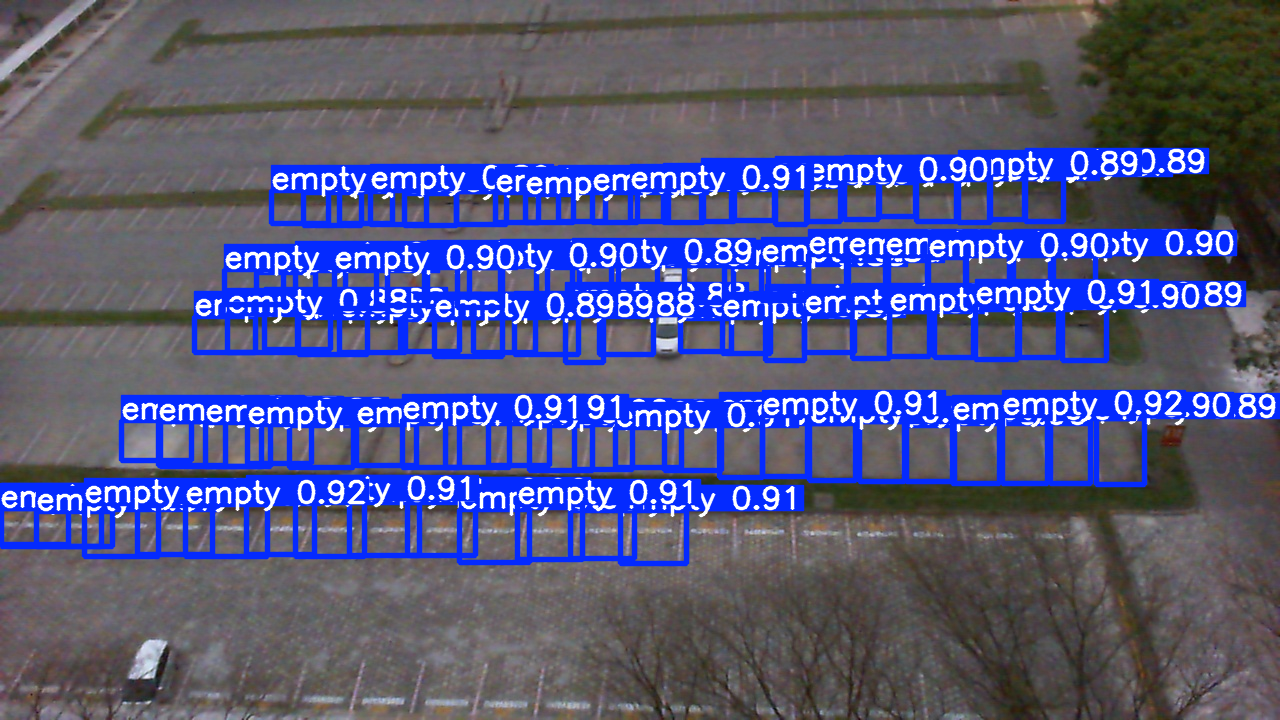

In [108]:
from PIL import Image
import os
import random
from ultralytics import YOLO

#model = YOLO("yolov8m.pt")

test_images_directory = "demo_images"

image_files = [f for f in os.listdir(test_images_directory) if f.lower().endswith(".jpg")]

random_image_filename = random.choice(image_files)
random_image_path = os.path.join(test_images_directory, random_image_filename)

results = model.predict(random_image_path)

result = results[0]

print(len(result.boxes))

Image.fromarray(result.plot()[:,:,::-1])


image 1/1 d:\Uni\F24\CV\CV-Parking-Lot-Project\parking-lot-e1629150613383.jpeg: 448x640 3 emptys, 13.1ms
Speed: 2.5ms preprocess, 13.1ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)
3


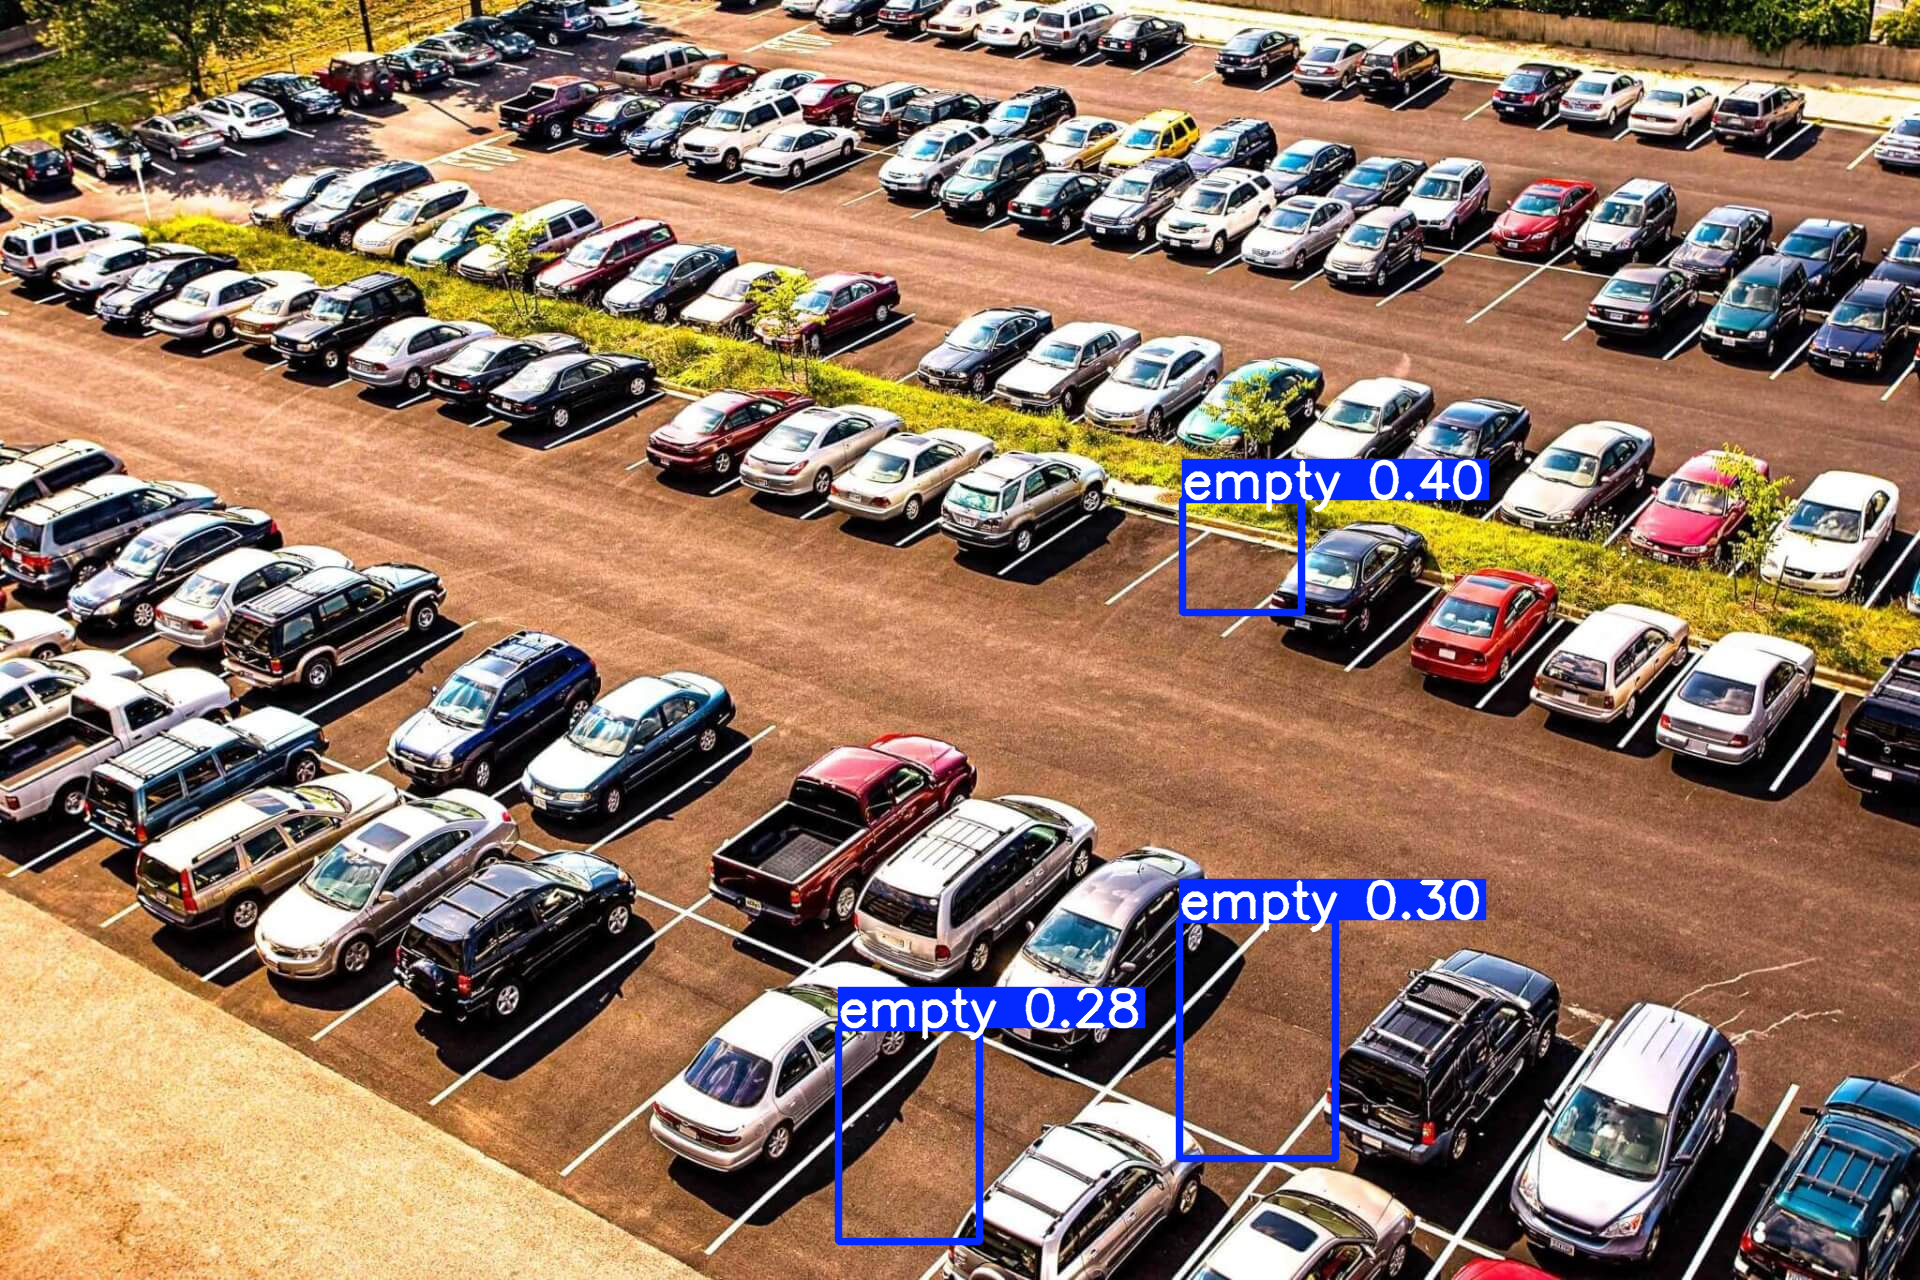

In [159]:
from ultralytics import YOLO
from PIL import Image

# Sample code to test the model on the images of your choice
model = YOLO("tests/yolo11s_1class/weights/epoch2.pt")
image_path = "parking-lot-e1629150613383.jpeg"
results = model.predict(image_path)

result = results[0]

print(len(result.boxes))

Image.fromarray(result.plot()[:,:,::-1])